In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# https://www.kaggle.com/datasets/megan3/groningen-crime-data-19962021

### load dataset

In [2]:
# https://www.kaggle.com/datasets/megan3/groningen-crime-data-19962021
csv_file = pd.read_csv("aangifte-politie_totaal.csv")
df = pd.DataFrame(csv_file)
df.head()

,hoofdgroep,main_group,aangifte,subgroup,Year_1996,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021
0,vermogensdelicten,property crimes,diefstal auto,theft car,327,428,351,334,262,330,...,67,75,70,63,82,50,43,31,27,17
1,vermogensdelicten,property crimes,diefstal motor/scooter,theft motorcycle/scooter,28,30,26,28,19,45,...,36,31,23,64,27,49,46,14,29,35
2,vermogensdelicten,property crimes,diefstal bromfiets/snorfiets,theft moped,438,404,418,560,301,271,...,485,485,454,488,397,332,377,401,317,259
3,vermogensdelicten,property crimes,diefstal fiets,theft bike,2842,319,3058,3322,3512,3098,...,3272,3605,3291,3549,3408,2363,1982,1983,1446,1809
4,vermogensdelicten,property crimes,diefstal af/uit auto,theft from car,2657,2712,2918,3087,3058,3251,...,905,931,885,1091,948,522,384,478,357,228


### data cleaning

In [3]:
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

In [4]:
df_transpose = df.transpose()
df_transpose = df_transpose.drop([df_transpose.index[0],df_transpose.index[1], df_transpose.index[2]])
df_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
subgroup,theft car,theft motorcycle/scooter,theft moped,theft bike,theft from car,theft from company,theft from home,shoplifting,pickpocketing,robbery (including bag theft),other property crimes,abuse/violence,sex crime,theft/human trafficking,destruction property damage
Year_1996,327,28,438,2842,2657,157,3162,1094,295,241,28,780,137,256,2014
Year_1997,428,30,404,319,2712,1559,2908,982,193,217,3229,870,135,246,2183
Year_1998,351,26,418,3058,2918,1761,2787,1188,387,227,2983,926,117,302,2428
Year_1999,334,28,560,3322,3087,1481,281,1241,375,271,3206,894,93,305,2244


In [5]:
headers = df_transpose.iloc[0].values
df_transpose.columns = headers
df_transpose = df_transpose.drop(df_transpose.index[0])
df_transpose.head()

,theft car,theft motorcycle/scooter,theft moped,theft bike,theft from car,theft from company,theft from home,shoplifting,pickpocketing,robbery (including bag theft),other property crimes,abuse/violence,sex crime,theft/human trafficking,destruction property damage
Year_1996,327,28,438,2842,2657,157,3162,1094,295,241,28,780,137,256,2014
Year_1997,428,30,404,319,2712,1559,2908,982,193,217,3229,870,135,246,2183
Year_1998,351,26,418,3058,2918,1761,2787,1188,387,227,2983,926,117,302,2428
Year_1999,334,28,560,3322,3087,1481,281,1241,375,271,3206,894,93,305,2244
Year_2000,262,19,301,3512,3058,1852,2279,1169,383,248,3037,975,140,386,2249


In [6]:
# simplify the transposed dataset
df_transpose = df_transpose.reset_index()
df_transpose = df_transpose.join(df_transpose['index'].str.split('_', 1, expand=True).rename(columns={0:'Years', 1:'Jaar'}))
df_transpose.drop(columns=['Years', 'index'], axis=1, inplace=True)
first_column = df_transpose.pop('Jaar')
df_transpose.insert(0, 'Year', first_column)
df_transpose = df_transpose.astype('int')

C:\Users\alexd\AppData\Local\Temp\ipykernel_12628\1258864247.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_transpose = df_transpose.join(df_transpose['index'].str.split('_', 1, expand=True).rename(columns={0:'Years', 1:'Jaar'}))


In [7]:
df_transpose.head()

,Year,theft car,theft motorcycle/scooter,theft moped,theft bike,theft from car,theft from company,theft from home,shoplifting,pickpocketing,robbery (including bag theft),other property crimes,abuse/violence,sex crime,theft/human trafficking,destruction property damage
0,1996,327,28,438,2842,2657,157,3162,1094,295,241,28,780,137,256,2014
1,1997,428,30,404,319,2712,1559,2908,982,193,217,3229,870,135,246,2183
2,1998,351,26,418,3058,2918,1761,2787,1188,387,227,2983,926,117,302,2428
3,1999,334,28,560,3322,3087,1481,281,1241,375,271,3206,894,93,305,2244
4,2000,262,19,301,3512,3058,1852,2279,1169,383,248,3037,975,140,386,2249


In [8]:
df_transpose.describe()

,Year,theft car,theft motorcycle/scooter,theft moped,theft bike,theft from car,theft from company,theft from home,shoplifting,pickpocketing,robbery (including bag theft),other property crimes,abuse/violence,sex crime,theft/human trafficking,destruction property damage
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.00000,26.000000,26.000000,26.000000,26.000000
mean,2008.500000,159.961538,30.384615,365.346154,2881.769231,1533.576923,740.923077,1263.807692,938.692308,398.730769,133.538462,2447.00000,887.307692,99.115385,456.961538,1716.615385
std,7.648529,124.587152,12.185489,86.701761,795.686738,1010.707680,593.331336,822.015816,228.652709,145.681998,76.237120,919.63558,128.993882,19.279682,99.096511,675.941008
min,1996.000000,17.000000,13.000000,188.000000,319.000000,103.000000,150.000000,137.000000,113.000000,84.000000,23.000000,28.00000,524.000000,68.000000,246.000000,124.000000
25%,2002.250000,67.750000,23.250000,312.500000,2799.250000,890.000000,346.500000,668.000000,862.000000,301.750000,60.000000,2087.75000,867.750000,88.250000,425.000000,1569.500000
50%,2008.500000,106.000000,28.000000,351.500000,3148.000000,1272.000000,414.500000,1187.500000,950.000000,410.500000,132.000000,2709.50000,928.000000,97.500000,469.000000,1906.500000
75%,2014.750000,283.000000,34.250000,414.500000,3332.500000,2595.500000,1241.750000,1601.000000,1073.250000,484.250000,198.000000,3023.50000,957.000000,107.250000,528.750000,2204.750000
max,2021.000000,428.000000,64.000000,560.000000,3829.000000,3251.000000,1852.000000,3162.000000,1241.000000,687.000000,271.000000,3544.00000,1103.000000,140.000000,612.000000,2442.000000


In [9]:
# normalize the transposed data set
df_normalized = df_transpose.copy(deep=True)
s0 = df_normalized.iloc[:,1:]
df_normalized.iloc[:,1:] = (s0 - s0.mean()) / (s0.max() - s0.min())
df_normalized.head()

,Year,theft car,theft motorcycle/scooter,theft moped,theft bike,theft from car,theft from company,theft from home,shoplifting,pickpocketing,robbery (including bag theft),other property crimes,abuse/violence,sex crime,theft/human trafficking,destruction property damage
0,1996,0.406420,-0.046757,0.195306,-0.011330,0.356869,-0.343081,0.627502,0.137684,-0.172024,0.433313,-0.687998,-0.185333,0.526175,-0.549075,0.128294
1,1997,0.652162,-0.007541,0.103908,-0.730134,0.374340,0.480656,0.543535,0.038393,-0.341179,0.336538,0.222412,-0.029892,0.498397,-0.576398,0.201201
2,1998,0.464814,-0.085973,0.141543,0.050208,0.439779,0.599340,0.503535,0.221017,-0.019454,0.376861,0.152446,0.066826,0.248397,-0.423392,0.306896
3,1999,0.423451,-0.046757,0.523263,0.125422,0.493463,0.434828,-0.324895,0.268003,-0.039355,0.554280,0.215870,0.011558,-0.084936,-0.415195,0.227517
4,2000,0.248269,-0.223228,-0.172974,0.179553,0.484251,0.652807,0.335601,0.204173,-0.026088,0.461538,0.167804,0.151455,0.567842,-0.193884,0.229674


### exploratory data visualisations

### Import Libraries

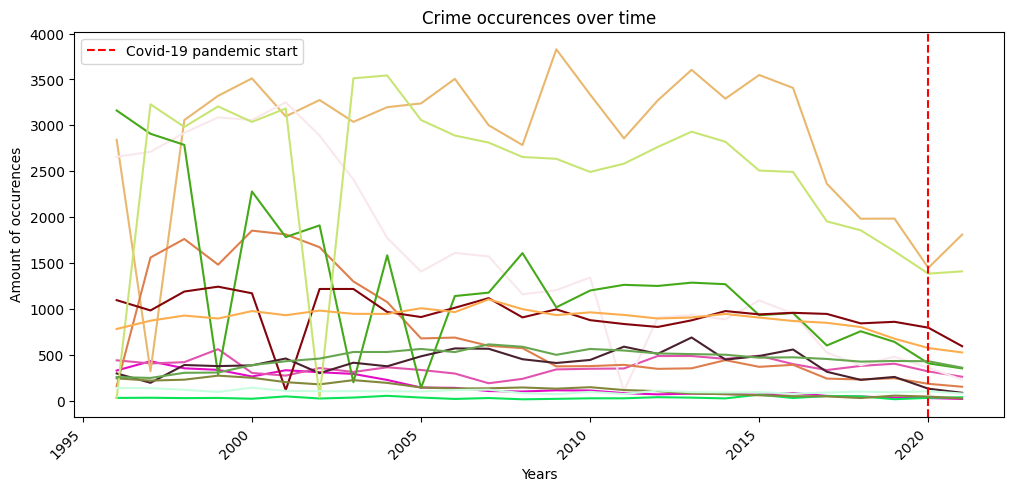

In [10]:
plt.figure(figsize=(12, 5))
for i in range(14):
    plt.plot(df_transpose['Year'], df_transpose.iloc[:,i+1],color =np.random.rand(3,)) 
plt.axvline(x= 2020, color='red', linestyle='--', label='Covid-19 pandemic start')
plt.title("Crime occurences over time")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Years")
plt.ylabel("Amount of occurences")
plt.legend()
plt.show()

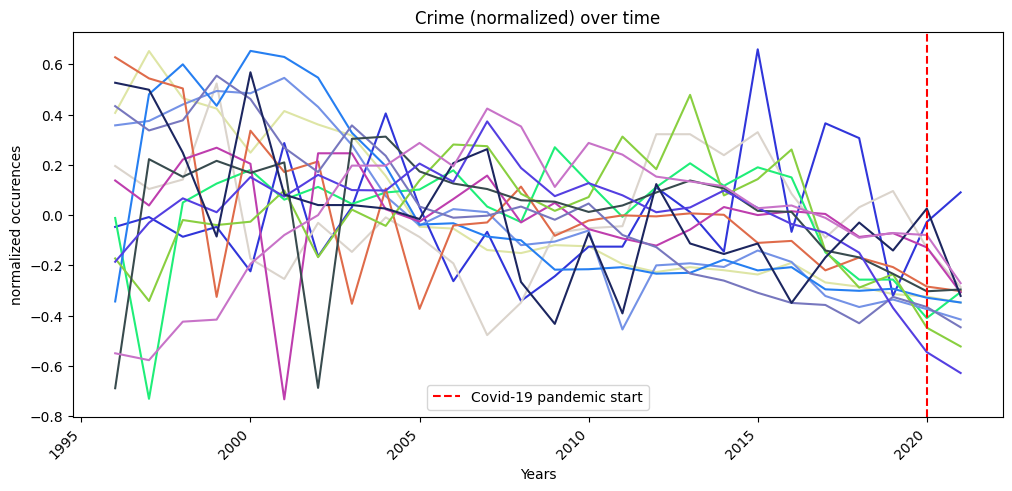

In [11]:
plt.figure(figsize=(12, 5))
for i in range(14):
    plt.plot(df_normalized['Year'], df_normalized.iloc[:,i+1],color =np.random.rand(3,))     
plt.axvline(x= 2020, color='red', linestyle='--', label='Covid-19 pandemic start')
plt.title("Crime (normalized) over time")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Years")
plt.ylabel("normalized occurences")
plt.legend()
plt.show()

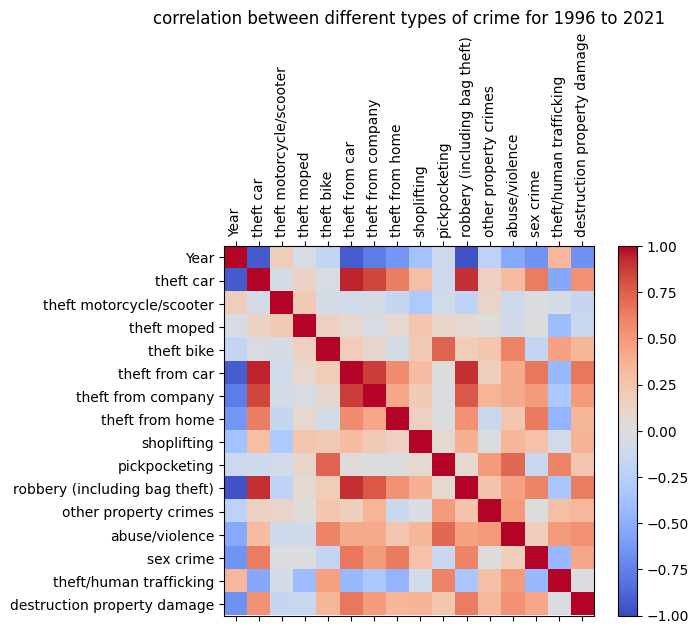

In [12]:
corr = df_normalized.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_normalized.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_normalized.columns)
ax.set_yticklabels(df_normalized.columns)
plt.title("correlation between different types of crime for 1996 to 2021")
plt.show()

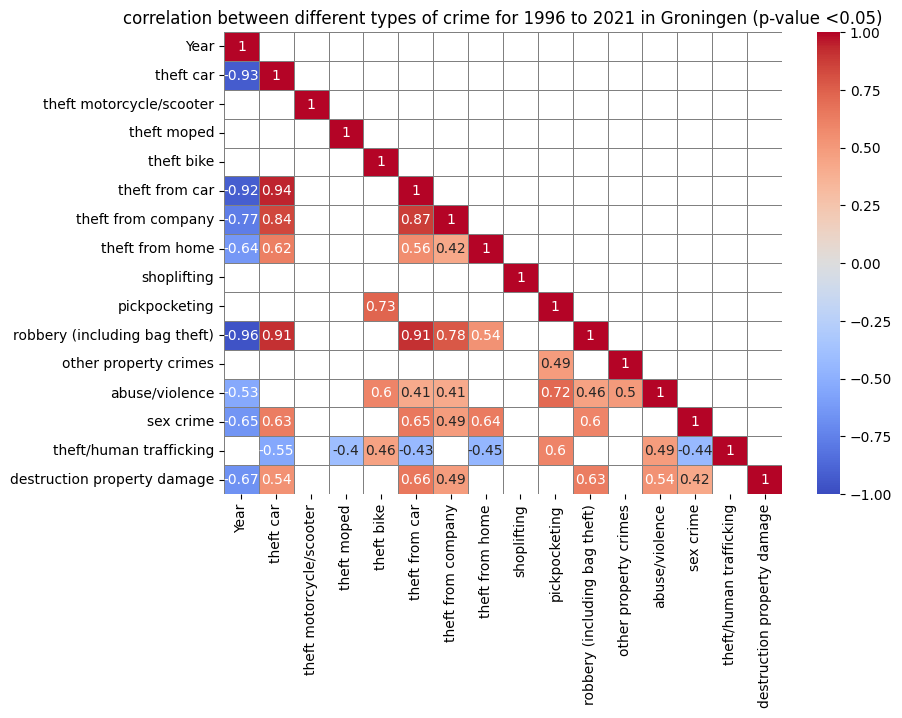

In [13]:
def corr_sig(df):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

def plot_cor_matrix(corr, mask):
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=0.5, linecolor='grey')
    plt.title("correlation between different types of crime for 1996 to 2021 in Groningen (p-value <0.05)")

corr = df_normalized.corr()                           
p_values = corr_sig(df_normalized)                  
mask = np.invert(np.tril(p_values<0.05))  
plot_cor_matrix(corr,mask)

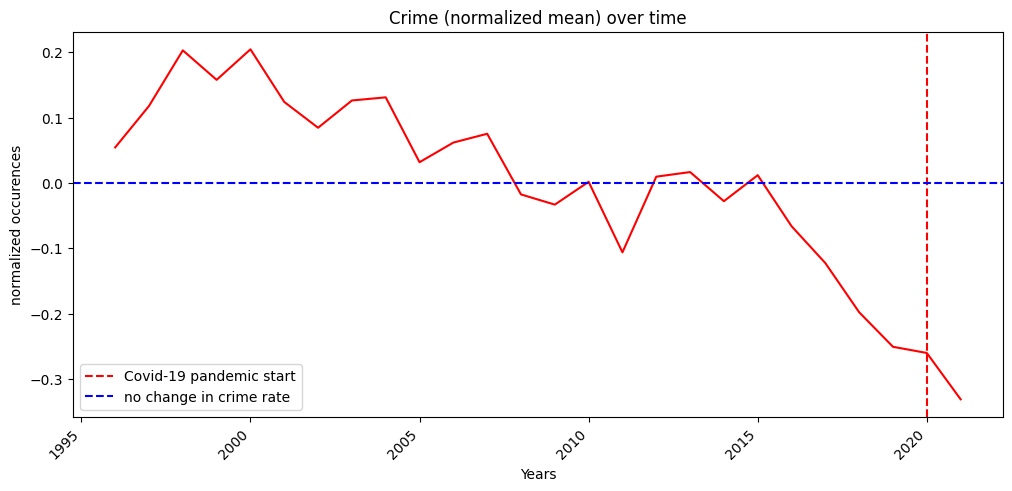

In [14]:
# add a column which is the mean of the other normalized dataframe columns.
mean = df_normalized.iloc[:, 1:].mean(axis=1)
df_normalized = df_normalized.assign(mean=mean)

plt.figure(figsize=(12, 5))
plt.plot(df_normalized['Year'], df_normalized['mean'],color = 'red')     
plt.axvline(x= 2020, color='red', linestyle='--', label='Covid-19 pandemic start')
plt.axhline(y= 0, color='blue', linestyle='--', label='no change in crime rate')

plt.title("Crime (normalized mean) over time")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Years")
plt.ylabel("normalized occurences")
plt.legend()
plt.show()

### building the model
Im using a Multivariate LSTM Model
 -> https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [17]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# split into train and test sets
df = np.array(df_normalized['mean'])

#scaler = MinMaxScaler(feature_range=(0, 1))
#df.array.reshape(-1, 1)
#dataset = scaler.fit_transform(df)

train_ind = int(len(df)*0.67)
train = df[:train_ind]
test = df[train_ind:]
print(len(train), len(test))

17 9


In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX))
print(len(testX))



14
6


In [19]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,)

# Training Phase
model.summary()

Epoch 1/100
14/14 - 2s - loss: 0.0127 - 2s/epoch - 166ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0107 - 45ms/epoch - 3ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0093 - 40ms/epoch - 3ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0086 - 40ms/epoch - 3ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0078 - 37ms/epoch - 3ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0075 - 35ms/epoch - 3ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0073 - 35ms/epoch - 3ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0071 - 36ms/epoch - 3ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0070 - 35ms/epoch - 3ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0070 - 41ms/epoch - 3ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0069 - 37ms/epoch - 3ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0068 - 36ms/epoch - 3ms/step
Epoch 13/100
14/14 - 0s - loss: 0.0069 - 33ms/epoch - 2ms/step
Epoch 14/100
14/14 - 0s - loss: 0.0067 - 34ms/epoch - 2ms/step
Epoch 15/100
14/14 - 0s - loss: 0.0066 - 34ms/epoch - 2ms/step
Epoch 16/100
14/14 - 0s - loss: 0.0066 - 36ms/epoch - 3ms/step
E

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainY[0])
print('------')
print(trainPredict[:,0])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
trainScore
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


1/1 [==============================] - 0s 29ms/step
0.20285618555454085
------
[ 0.07236139  0.14131464  0.15068442  0.15814629  0.13317093  0.08201685
  0.08822088  0.10682018  0.05807023  0.03644536  0.05408444  0.01446607
 -0.02392386 -0.01399464]
Train Score: 0.06 RMSE
Test Score: 0.10 RMSE


In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot = np.zeros((len(trainPredict), 1))
trainPredictPlot[0:len(trainPredict)+look_back] = trainPredict[0:]
print(len(trainPredictPlot))

14


In [23]:
testPredictPlot = np.empty_like(df)
testPredictPlot = np.full((len(df), 1), np.nan)
testPredictPlot[len(trainPredict)+look_back+4:len(df), :] = testPredict
print(len(testPredict))
print(len(df))

6
26


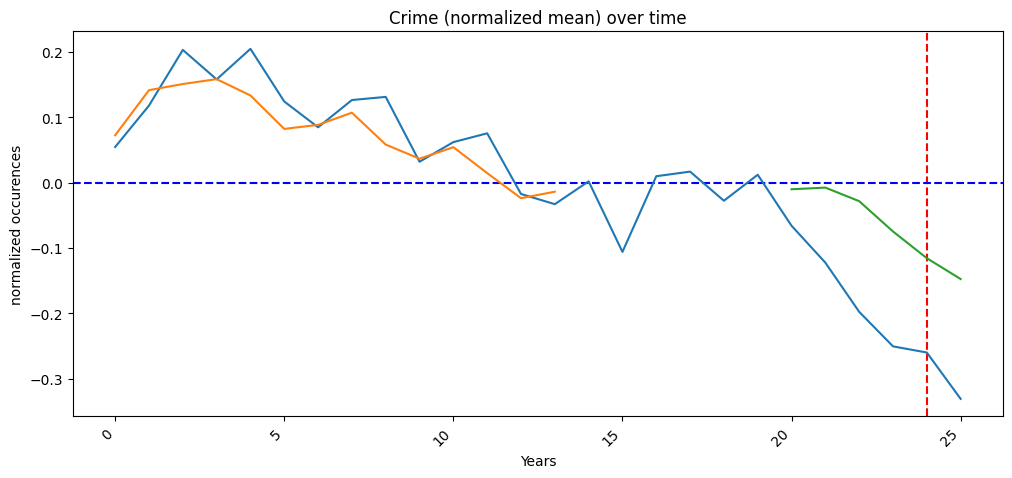

In [24]:
plt.figure(figsize=(12, 5))

plt.title("Crime (normalized mean) over time")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Years")
plt.ylabel("normalized occurences")

plt.axvline(x= 24, color='red', linestyle='--', label='Covid-19 pandemic start')
plt.axhline(y= 0, color='blue', linestyle='--', label='no change in crime rate')

plt.plot(df)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

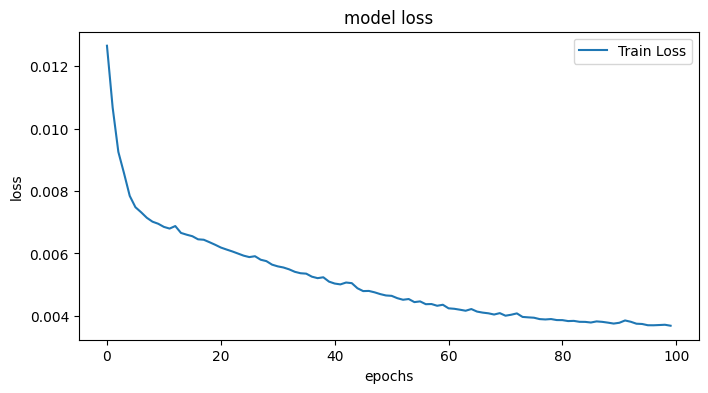

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();